In [1]:
import json
from itertools import combinations
import numpy as np
import networkx as nx
import cassiopeia as cas
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

import sys
import os
sys.path.insert(0, os.path.abspath('../scripts/'))
import utils

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15

In [2]:
def annotate_state(node_id, transitions, potencies):
    if len(transitions[node_id]) == 0:
        potencies[node_id] = node_id
        return [node_id]
    else:
        all_states = []
        for i in transitions[node_id]:
            all_states.extend(annotate_state(i, transitions, potencies))
        potencies[node_id] = all_states
        return all_states

def check_duplicates(list_of_lists):
  """Checks for duplicate lists within a list of lists."""

  seen = set()
  duplicates = []

  for sublist in list_of_lists:
    # Convert the sublist to a tuple to make it hashable
    t = tuple(sublist)
    if t in seen:
      duplicates.append(sublist)
    else:
      seen.add(t)

  return duplicates

# Make binary tree cell differentiation maps

In [11]:
num_sample = 12
# num_sample = 8
for fi in list(range(2, 12)) + list(range(17, 27)):
    qfm_path = f"../data/simulations/inputs/differentiation_maps/supplementary_data_1_fate_map_panel/fate_map{fi:04}.json"
    
    with open(qfm_path) as f:
        # Load the JSON data as a dictionary
        data = json.load(f)

    G = nx.DiGraph()
    for id, children in data["merge"].items():
        G.add_nodes_from([id, children[0], children[1]])
        G.add_edge(id, children[0])
        G.add_edge(id, children[1])

    tree = cas.data.CassiopeiaTree(tree = G)

    chosen_tips = np.random.choice(data["tip_id"], size = num_sample, replace = False)

    tree.remove_leaves_and_prune_lineages(list(set(tree.leaves) - set(chosen_tips)))
    tree.collapse_unifurcations()

    edge_dict = defaultdict(list)
    edge_dict['root'] = [data['root_id']]
    for u, v in tree.breadth_first_traverse_edges():
        edge_dict[u].append(v)
    for i in tree.leaves:
        edge_dict[i] = []

    id_to_progen = {}
    annotate_state(data['root_id'], edge_dict, id_to_progen)
    tot_time = data["target_time"]
    
    total_times = dict([(u, t/data['target_time']) for u, t in data["diff_time"].items() if t != 'Inf' and u in edge_dict])
    for i in tree.leaves:
        total_times[i] = 1.0
    
    prob_dict = dict(zip(data['diff_mode_probs'].keys(),[i[:2] for i in data['diff_mode_probs'].values()]))
    for i in data['diff_mode_probs'].keys():
        if i not in edge_dict:
            del prob_dict[i]
    root_state = data["root_id"]

    incidence_dict = dict(zip(tree.leaves, [1] * len(tree.leaves)))

    # f = open(f"../data/simulations/inputs/differentiation_maps/bin_tree/type_{num_sample}/graph_fate_map{fi:04}.txt", "w")
    # f.write(json.dumps(edge_dict) + '\n')
    # f.write(json.dumps(total_times) + '\n')
    # f.write(json.dumps(id_to_progen) + '\n')
    # f.write(data["root_id"] + '\n')
    # f.write(json.dumps(incidence_dict) + '\n')
    # f.write(json.dumps(prob_dict) + '\n')
    # f.close()

# Make polytomy tree cell differentiation maps

In [12]:
for fi in list(range(2, 12)) + list(range(17, 27)):
    qfm_path = f"../data/simulations/inputs/differentiation_maps/supplementary_data_1_fate_map_panelfate_map{fi:04}.json"
    
    with open(qfm_path) as f:
        # Load the JSON data as a dictionary
        data = json.load(f)
    
    edge_dict = data["merge"]
    edge_dict['root'] = [data['root_id']]
    for i in data["tip_id"]:
        edge_dict[i] = []

    tot_time = data["target_time"]
    
    total_times = dict([(u, t/data['target_time']) for u, t in data["diff_time"].items() if t != 'Inf'])
    for i in data["tip_id"]:
        total_times[i] = 1.0
    
    # okay_flag = False
    # while not okay_flag:

    merge_edge_dict = dict(zip(edge_dict.keys(), edge_dict.values()))
    id_to_progen = {}
    annotate_state(data['root_id'], merge_edge_dict, id_to_progen)
    
    progen_forks = []
    for ind, c in merge_edge_dict.items():
        if len(c) == 2:
            if "-" not in c[0] or "-" not in c[1]:
                if len(id_to_progen[ind]) <= 6:
                    progen_forks.append(ind)

    prob_dict = dict(zip(data['diff_mode_probs'].keys(),[i[:2] for i in data['diff_mode_probs'].values()]))

    chosen_flag = False
    while not chosen_flag:
        chosen_forks = np.random.choice(progen_forks, 2, replace = False)
        if chosen_forks[0] not in merge_edge_dict[chosen_forks[1]] and chosen_forks[1] not in merge_edge_dict[chosen_forks[0]]:
            chosen_flag = True
    
    
    for chosen_fork in chosen_forks:
        children = merge_edge_dict[chosen_fork]
        merge_edge = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    #     

        if "-" in children[0] or "-" in children[1]:
            if "-" in children[0]:
                prog_child = 1
            else:
                prog_child = 0

            if prog_child == 0:
                prob_dict[chosen_fork] = prob_dict[children[0]] + [prob_dict[chosen_fork][1]]
            else:
                prob_dict[chosen_fork] = [prob_dict[chosen_fork][0]] + prob_dict[children[1]]
            prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]

            if prog_child == 0:
                merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + [children[1]]
            else:
                merge_edge_dict[chosen_fork] = [children[0]] + merge_edge_dict[children[1]]
            
        else:
            merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
        
            prob_dict[chosen_fork] = prob_dict[children[0]] + prob_dict[children[1]]
            prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]
    
        for c in children:
            if "-" not in c:
                del merge_edge_dict[c]
                del id_to_progen[c]
                del total_times[c]
                del prob_dict[c]

    incidence_dict = dict(zip(data['tip_id'], [1] * len(data['tip_id'])))

    for ind, p in merge_edge_dict.items():
        if len(p) > 1:
            merge_edge_dict[ind] = list(set(p))

    # f = open(f"../data/simulations/inputs/differentiation_maps/poly_tree/type_16/graph_fate_map{fi:04}.txt", "w")
    # f.write(json.dumps(merge_edge_dict) + '\n')
    # f.write(json.dumps(total_times) + '\n')
    # f.write(json.dumps(id_to_progen) + '\n')
    # f.write(data["root_id"] + '\n')
    # f.write(json.dumps(incidence_dict) + '\n')
    # f.write(json.dumps(prob_dict) + '\n')
    # f.close()

In [13]:
num_sample = 10
# num_sample = 6
for fi in list(range(2, 12)) + list(range(17, 27)):
    fm_path = f"../data/simulations/inputs/differentiation_maps/bin_tree/type_{num_sample + 2}/graph_fate_map{fi:04}.txt"
    
    graph_dicts = []
    with open(fm_path) as graph_file:
        for line in graph_file:
            graph_dicts.append(json.loads(line))

    edge_dict = {}
    for key, value in graph_dicts[0].items():
        edge_dict[str(key)] = value

    total_times = {}
    for key, value in graph_dicts[1].items():
        total_times[str(key)] = value

    id_to_progen_old = {}
    for key, value in graph_dicts[2].items():
        id_to_progen_old[str(key)] = value

    incidence_dict = {}
    for key, value in graph_dicts[4].items():
        incidence_dict[str(key)] = value

    prob_dict = {}
    for key, value in graph_dicts[5].items():
        prob_dict[str(key)] = value


    merge_edge_dict = dict(zip(edge_dict.keys(), edge_dict.values()))
    id_to_progen = {}
    annotate_state(data['root_id'], merge_edge_dict, id_to_progen)
    
    progen_forks = []
    for ind, c in merge_edge_dict.items():
        if len(c) == 2:
            if "-" not in c[0] or "-" not in c[1]:
                if len(id_to_progen[ind]) <= 6:
                    progen_forks.append(ind)

    chosen_flag = False
    iters = 0
    while not chosen_flag:
        chosen_forks = np.random.choice(progen_forks, 2, replace = False)
        if chosen_forks[0] not in merge_edge_dict[chosen_forks[1]] and chosen_forks[1] not in merge_edge_dict[chosen_forks[0]]:
            chosen_flag = True
        iters += 1
        if iters > 100:
            print("not enough valid forks")
            break
    
    for chosen_fork in chosen_forks:
        children = merge_edge_dict[chosen_fork]
        merge_edge = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    #     

        if "-" in children[0] or "-" in children[1]:
            if "-" in children[0]:
                prog_child = 1
            else:
                prog_child = 0

            if prog_child == 0:
                prob_dict[chosen_fork] = prob_dict[children[0]] + [prob_dict[chosen_fork][1]]
            else:
                prob_dict[chosen_fork] = [prob_dict[chosen_fork][0]] + prob_dict[children[1]]
            prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]

            if prog_child == 0:
                merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + [children[1]]
            else:
                merge_edge_dict[chosen_fork] = [children[0]] + merge_edge_dict[children[1]]
            
        else:
            merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
        
            prob_dict[chosen_fork] = prob_dict[children[0]] + prob_dict[children[1]]
            prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]
    
        for c in children:
            if "-" not in c:
                del merge_edge_dict[c]
                del id_to_progen[c]
                del total_times[c]
                del prob_dict[c]

    incidence_dict = dict(zip(data['tip_id'], [1] * len(data['tip_id'])))

    for ind, p in merge_edge_dict.items():
        if len(p) > 1:
            merge_edge_dict[ind] = list(set(p))

    # f = open(f"../data/simulations/inputs/differentiation_maps/poly_tree/type_{num_sample}/graph_fate_map{fi:04}.txt", "w")
    # f.write(json.dumps(merge_edge_dict) + '\n')
    # f.write(json.dumps(total_times) + '\n')
    # f.write(json.dumps(id_to_progen) + '\n')
    # f.write(data["root_id"] + '\n')
    # f.write(json.dumps(incidence_dict) + '\n')
    # f.write(json.dumps(prob_dict) + '\n')
    # f.close()

# Make DAG cell differentiation maps

In [14]:
for fi in list(range(2, 12)) + list(range(17, 27)):
    qfm_path = f"../data/simulations/inputs/differentiation_maps/supplementary_data_1_fate_map_panel/fate_map{fi:04}.json"
    
    with open(qfm_path) as f:
        # Load the JSON data as a dictionary
        data = json.load(f)
    
    edge_dict = data["merge"]
    edge_dict['root'] = [data['root_id']]
    for i in data["tip_id"]:
        edge_dict[i] = []
    
    okay_flag = False
    while not okay_flag:

        merge_edge_dict = {}

        tip_pairs = {}
        chosen_tip_merge = np.random.choice(data['tip_id'], 4, replace = False)
        tip_pairs[chosen_tip_merge[0]] = chosen_tip_merge[1]
        tip_pairs[chosen_tip_merge[2]] = chosen_tip_merge[3]
        
        for ind, e in edge_dict.items():
            if len(e) > 1:
                merge_edge_dict[ind] = [tip_pairs[i] if i in tip_pairs else i for i in e]
            else:
                merge_edge_dict[ind] = e
        
        for i in tip_pairs.keys():
            del merge_edge_dict[i]
        
        id_to_progen = {}
        annotate_state(data['root_id'], merge_edge_dict, id_to_progen)

        for ind, p in id_to_progen.items():
            if type(p) == list:
                id_to_progen[ind] = list(set(p))
    
        if len(check_duplicates([sorted(po) for po in id_to_progen.values()])) == 0:
            okay_flag = True

        for ind, p in id_to_progen.items():
            if type(p) == list and len(set(p)) == 1:
                okay_flag = False
    
    progen_forks = []
    for ind, c in merge_edge_dict.items():
        if len(c) == 2:
            if "-" not in c[0] and "-" not in c[1]:
                if len(id_to_progen[ind]) <= 6:
                    progen_forks.append(ind)
                    
    chosen_fork = np.random.choice(progen_forks)
    
    tot_time = data["target_time"]
    
    total_times = dict([(u, t/data['target_time']) for u, t in data["diff_time"].items() if t != 'Inf'])
    for i in data["tip_id"]:
        total_times[i] = 1.0

    children = merge_edge_dict[chosen_fork]
    merge_edge = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    prob_dict = dict(zip(data['diff_mode_probs'].keys(),[i[:2] for i in data['diff_mode_probs'].values()]))
    
    if len(merge_edge) != len(set(merge_edge)):

        prob_vals_left = dict(zip(merge_edge_dict[children[0]], prob_dict[children[0]]))
        prob_vals_right = dict(zip(merge_edge_dict[children[1]], prob_dict[children[1]]))

        prob_vals = {}
        merge_edge = list(set(merge_edge))
        for v in merge_edge:
            val = 0
            if v in prob_vals_left:
                val += prob_vals_left[v]
            if v in prob_vals_right:
                val += prob_vals_right[v]
            prob_vals[v] = val
        merge_edge_dict[chosen_fork] = merge_edge
        prob_dict[chosen_fork] = [i/sum(list(prob_vals.values())) for i in list(prob_vals.values())]

        
    else:
        merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    
        prob_dict[chosen_fork] = prob_dict[children[0]] + prob_dict[children[1]]
        prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]

    for c in children:
        del merge_edge_dict[c]
        del id_to_progen[c]
        del total_times[c]
        del prob_dict[c]

    incidence_dict = dict(zip(data['tip_id'], [1] * len(data['tip_id'])))
    for i in tip_pairs.values():
        incidence_dict[i] = 2
    for i in tip_pairs.keys():
        del incidence_dict[i]

    for ind, p in merge_edge_dict.items():
        if len(p) > 1:
            merge_edge_dict[ind] = list(set(p))

    # f = open(f"../data/simulations/inputs/differentiation_maps/graph/type_14/graph_fate_map{fi:04}.txt", "w")
    # f.write(json.dumps(merge_edge_dict) + '\n')
    # f.write(json.dumps(total_times) + '\n')
    # f.write(json.dumps(id_to_progen) + '\n')
    # f.write(data["root_id"] + '\n')
    # f.write(json.dumps(incidence_dict) + '\n')
    # f.write(json.dumps(prob_dict) + '\n')
    # f.close()

In [15]:
num_sample = 6
for fi in list(range(2, 12)) + list(range(17, 27)):
    fm_path = f"../data/simulations/inputs/differentiation_maps/bin_tree/type_{num_sample + 2}/graph_fate_map{fi:04}.txt"
    
    graph_dicts = []
    with open(fm_path) as graph_file:
        for line in graph_file:
            graph_dicts.append(json.loads(line))

    edge_dict = {}
    for key, value in graph_dicts[0].items():
        edge_dict[str(key)] = value

    total_times = {}
    for key, value in graph_dicts[1].items():
        total_times[str(key)] = value

    id_to_progen_old = {}
    for key, value in graph_dicts[2].items():
        id_to_progen_old[str(key)] = value

    incidence_dict = {}
    for key, value in graph_dicts[4].items():
        incidence_dict[str(key)] = value

    states = list(max(id_to_progen_old.values(), key=len))
    
    okay_flag = False
    while not okay_flag:

        merge_edge_dict = {}

        tip_pairs = {}
        chosen_tip_merge = np.random.choice(states, 4, replace = False)
        tip_pairs[chosen_tip_merge[0]] = chosen_tip_merge[1]
        tip_pairs[chosen_tip_merge[2]] = chosen_tip_merge[3]
        
        for ind, e in edge_dict.items():
            if len(e) > 1:
                merge_edge_dict[ind] = [tip_pairs[i] if i in tip_pairs else i for i in e]
            else:
                merge_edge_dict[ind] = e
        
        for i in tip_pairs.keys():
            del merge_edge_dict[i]
        
        id_to_progen = {}
        annotate_state(str(graph_dicts[3]), merge_edge_dict, id_to_progen)

        for ind, p in id_to_progen.items():
            if type(p) == list:
                id_to_progen[ind] = list(set(p))
    
        if len(check_duplicates([sorted(po) for po in id_to_progen.values()])) == 0:
            okay_flag = True

        for ind, p in id_to_progen.items():
            if type(p) == list and len(set(p)) == 1:
                okay_flag = False
    
    progen_forks = []
    for ind, c in merge_edge_dict.items():
        if len(c) == 2:
            if "-" not in c[0] and "-" not in c[1]:
                if len(id_to_progen[ind]) <= 6:
                    progen_forks.append(ind)
                    
    chosen_fork = np.random.choice(progen_forks)

    children = merge_edge_dict[chosen_fork]
    merge_edge = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    prob_dict = dict(zip(data['diff_mode_probs'].keys(),[i[:2] for i in data['diff_mode_probs'].values()]))
    
    if len(merge_edge) != len(set(merge_edge)):

        prob_vals_left = dict(zip(merge_edge_dict[children[0]], prob_dict[children[0]]))
        prob_vals_right = dict(zip(merge_edge_dict[children[1]], prob_dict[children[1]]))

        prob_vals = {}
        merge_edge = list(set(merge_edge))
        for v in merge_edge:
            val = 0
            if v in prob_vals_left:
                val += prob_vals_left[v]
            if v in prob_vals_right:
                val += prob_vals_right[v]
            prob_vals[v] = val
        merge_edge_dict[chosen_fork] = merge_edge
        prob_dict[chosen_fork] = [i/sum(list(prob_vals.values())) for i in list(prob_vals.values())]

        
    else:
        merge_edge_dict[chosen_fork] = merge_edge_dict[children[0]] + merge_edge_dict[children[1]]
    
        prob_dict[chosen_fork] = prob_dict[children[0]] + prob_dict[children[1]]
        prob_dict[chosen_fork] = [i/sum(prob_dict[chosen_fork]) for i in prob_dict[chosen_fork]]
    
    for c in children:
        del merge_edge_dict[c]
        del id_to_progen[c]
        del total_times[c]
        del prob_dict[c]

    for i in tip_pairs.values():
        incidence_dict[i] = 2
    for i in tip_pairs.keys():
        del incidence_dict[i]

    for ind, p in merge_edge_dict.items():
        if len(p) > 1:
            merge_edge_dict[ind] = list(set(p))

    # f = open(f"../data/simulations/inputs/differentiation_maps/graph/type_{num_sample}/graph_fate_map{fi:04}.txt", "w")
    # f.write(json.dumps(merge_edge_dict) + '\n')
    # f.write(json.dumps(total_times) + '\n')
    # f.write(json.dumps(id_to_progen) + '\n')
    # f.write(str(graph_dicts[3]) + '\n')
    # f.write(json.dumps(incidence_dict) + '\n')
    # f.write(json.dumps(prob_dict) + '\n')
    # f.close()

# Fig 2d

In [13]:
def get_unrealizations(tree, states, progens):
    unrealizations, potency_sets_at_nodes, ind_to_potency_set = utils.min_unrealizations_for_set(tree, states, progens)
    for n in tree.depth_first_traverse_nodes(postorder = False):
        if tree.is_leaf(n):
            continue
        if n == tree.root:
            progen_ind = [i[0] for i in sorted(potency_sets_at_nodes[n].items(), key=lambda item: item[1][1])][0]
            progen_set = ind_to_potency_set[progen_ind]
            tree.set_attribute(n, "state_labels", list(sorted(progen_set)))
            continue
        parent = tree.parent(n)
    
        progen_inds = [i[0] for i in sorted(potency_sets_at_nodes[n].items(), key=lambda item: item[1][1])]
        for progen_ind in progen_inds:
            progen_set = ind_to_potency_set[progen_ind]
            if progen_set.issubset(set(tree.get_attribute(parent, "state_labels"))):
                tree.set_attribute(n, "state_labels", list(sorted(progen_set)))
                break
        leaf_set = set([tree.get_attribute(l, "state_labels")[0] for l in tree.leaves_in_subtree(n)])
        unrealizations += len(list(sorted(progen_set))) - len(leaf_set)
    return unrealizations


In [14]:
cell_types_list = ["graph/type_6"]
num_cells_list = [200]
fm_indices = [str(i).zfill(4) for i in list(range(2, 12)) + list(range(17, 27))]
tree_index_list = list(range(5))
cell_types_list_to_k = dict(zip(["graph/type_6"], [5]))
methods = ["Carta-tree", "EvoC"]

In [15]:
tree = cas.data.CassiopeiaTree(tree = "../data/simulations/inputs/trees/graph/type_6/cells_200/0017_tree_0.txt")
state_labels = pd.read_csv("../data/simulations/inputs/trees/graph/type_6/cells_200/0017_meta_0.txt", sep="\t")
utils.label_tree_with_leaf_states(tree, state_labels)
utils.impute_states_from_children(tree)

In [16]:
f = f"../data/simulations/results/ice_fase/graph/type_6/cells_200/0017_0_IceFaseGraph.nwk"
progens = [set(i) for i in utils.get_progens_from_tree_input(f)]
states = max(progens, key=len)
ice_u = get_unrealizations(tree, states, progens)

In [17]:
f = f"../data/simulations/results/evoC/graph/type_6/cells_200/0017_0_EvoCGraph.nwk"
progens = [set(i) for i in utils.get_progens_from_tree_input(f)]
evoc_u = get_unrealizations(tree, states, progens)

In [18]:
states = max(progens, key=len)

In [19]:
carta_us = []
carta_us.append(get_unrealizations(tree, states, [states]))

for i in range(2, 9):
    f = f"../data/simulations/results/carta_dag/graph/type_6/cells_200/0017_0_progenitors_{i}.txt"
    progens = [set(i) for i in utils.get_progens_from_ilp_output(f) if len(i) > 1]
    states = max(progens, key=len)
    carta_us.append(get_unrealizations(tree, states, progens))


In [20]:
carta_us_d = []
carta_us_d.append(get_unrealizations(tree, states, [states]))

for i in range(2, 6):
    f = f"../data/simulations/results/sim_pareto/res_progenitors_{i}.txt"
    progens = [set(i) for i in utils.get_progens_from_ilp_output(f) if len(i) > 1]
    states = max(progens, key=len)
    carta_us_d.append(get_unrealizations(tree, states, progens))

In [21]:
single_state_internal_nodes = []
terminal_single_state_nodes = []
for n in tree.internal_nodes:
    leaf_set = set(
        [
            tree.get_attribute(l, "state_labels")[0]
            for l in tree.leaves_in_subtree(n)
        ]
    )

    if len(leaf_set) == 1:
        single_state_internal_nodes.append(n)

good_nodes = list(set(tree.internal_nodes) - set(single_state_internal_nodes))
len(good_nodes)

312

In [30]:
df_data2 = pd.DataFrame([list(range(1, 9)), [d/len(good_nodes) for d in carta_us]]).T
df_data2.columns = ['k', 'discrepancy']
df_data2.to_csv("../data/simulations/results/carta_dag_pareto.csv")

In [31]:
df_data = pd.DataFrame([list(range(1, 9)), [d/len(good_nodes) for d in carta_us_d] + [carta_us_d[-1]/len(good_nodes)] * (8 - len(carta_us_d))]).T
df_data.columns = ['k', 'discrepancy']
df_data.to_csv("../data/simulations/results/carta_tree_pareto.csv")

In [33]:
pd.DataFrame([[ice_u/len(good_nodes), evoc_u/len(good_nodes)]], columns = ["ICE-FASE", "EvoC"]).to_csv("../data/simulations/results/other_methods_pareto.csv")

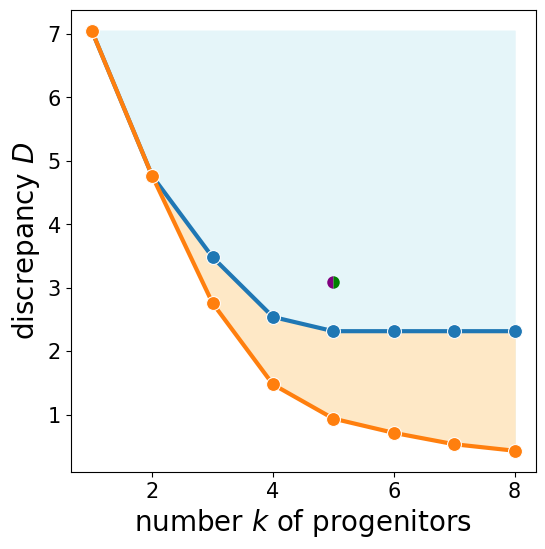

In [34]:
df_data2 = pd.read_csv("../data/simulations/results/carta_dag_pareto.csv")
df_data= pd.read_csv("../data/simulations/results/carta_tree_pareto.csv")
other_methods = pd.read_csv("../data/simulations/results/other_methods_pareto.csv")

carta_k = 5

plt.fill_between(df_data2['k'], df_data2['discrepancy'], max(df_data2['discrepancy']), color='#e5f5f9')
plt.fill_between(df_data['k'], df_data['discrepancy'], df_data2['discrepancy'], color='#FEE8C6')
sns.lineplot(df_data, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)
sns.lineplot(df_data2, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)

# plt.scatter(carta_k, df_data2['discrepancy'][carta_k - 1], marker='o', linewidth=1.5, s = 100, facecolors='none', color = 'blue', zorder = 5)
# plt.scatter(carta_k, df_data2['discrepancy'][carta_k - 1], marker='o', linewidth=2.0, s = 50, color = 'red', zorder = 4)

plt.plot(5, other_methods["ICE-FASE"][0], marker='o', fillstyle = "left", markeredgecolor='None', markersize = 9, c = 'purple', zorder = 6)
plt.plot(5, other_methods["EvoC"][0], marker='o', fillstyle = "right", markeredgecolor='None', markersize = 9, c = 'green', zorder = 6)

plt.gcf().set_size_inches((6,6))
plt.gca().set_xlabel(r'number $k$ of progenitors', fontsize=20)
plt.gca().set_ylabel(r'discrepancy $D$', fontsize=20)
# plt.savefig("final_LARRY_overview_panel.png", dpi = 300)
plt.show()

# Figure 2a,b,c and S9, S10, S11

In [3]:
method_color_dictionary = {'observed': 'gray',
                           'Carta-tree': sns.color_palette()[0],
                           'Carta-DAG': sns.color_palette()[1],
                           'EvoC': sns.color_palette()[2],
                           'ICE-FASE': sns.color_palette()[4]}

In [4]:
# cell_types_list = ["graph/type_6", "graph/type_10", "graph/type_14", "poly_tree/type_8", "poly_tree/type_12", "poly_tree/type_16", "bin_tree/type_8", "bin_tree/type_12", "bin_tree/type_16"]
# num_cells_list = [50, 100, 200]
# fm_indices = [str(i).zfill(4) for i in list(range(2, 12)) + list(range(17, 27))]
# tree_index_list = list(range(5))
# cell_types_list_to_k = dict(zip(["graph/type_6", "graph/type_10", "graph/type_14", "bin_tree/type_8", "bin_tree/type_12", "bin_tree/type_16"], [5, 9, 13, 7, 11, 15]))
# methods = ["Carta-tree", "Carta-DAG", "ICE-FASE", "EvoC"]
# # cell_types_list_to_k = dict(zip(cell_types_list, [9]))

In [5]:
# rows = []
# missing = []
# bad = []
# knees = []

# for ct in cell_types_list:
#     for nc in num_cells_list:
#         for fm in fm_indices:
#             for t in tree_index_list:
#                 for method in methods:
                    
    
#                     if method == "Carta-tree":
#                         if "poly_tree" in ct:
#                             graph_dicts = []
#                             with open(f"../data/simulations/inputs/differentiation_maps/{ct}/graph_fate_map{fm}.txt") as g_file:
#                                 for line in g_file:
#                                     graph_dicts.append(json.loads(line))
                    
#                             edge_dict = {}
#                             for key, value in graph_dicts[0].items():
#                                 edge_dict[str(key)] = value
                    
#                             k_center = len([i for i in edge_dict.values() if len(i) > 1])
#                             k_list = list(range(max(1, k_center - 3), k_center + 4))
#                             discps = []
#                             for k in k_list:
#                                 discps.append(pd.read_csv(f"../data/simulations/results/carta_tree/{ct}/cells_{nc}/{fm}_{t}_results_{k}.txt", sep = "\t")["objective_score"][0])
#                             y = discps
#                             x = k_list
#                             kneedle = KneeLocator(x, y, S = 0.1, curve = "convex", direction = "decreasing")
#                             knees.append(kneedle.knee)
                    
#                             if kneedle.knee is None:
#                                 print(fm, t, "no_knee")
#                                 knee = np.random.choice(x)
#                             else:
#                                 knee = kneedle.knee
#                             knee = k_center
                                
#                             f = f"../data/simulations/results/carta_tree/{ct}/cells_{nc}/{fm}_{t}_progenitors_{knee}.txt"
#                             res_progens = utils.get_progens_from_ilp_output(f)
                            
#                         else:
#                             k = cell_types_list_to_k[ct]
#                             f = f"../data/simulations/results/carta_tree/{ct}/cells_{nc}/{fm}_{t}_progenitors_{k}.txt"
#                             res_progens = utils.get_progens_from_ilp_output(f)
                            
                        
#                     elif method == "Carta-DAG":
#                         if "poly_tree" in ct:
#                             graph_dicts = []
#                             with open(f"../data/simulations/inputs/differentiation_maps/{ct}/graph_fate_map{fm}.txt") as g_file:
#                                 for line in g_file:
#                                     graph_dicts.append(json.loads(line))
                    
#                             edge_dict = {}
#                             for key, value in graph_dicts[0].items():
#                                 edge_dict[str(key)] = value
                    
#                             k_center = len([i for i in edge_dict.values() if len(i) > 1])
#                             k_list = list(range(max(1, k_center - 3), k_center + 4))
                            
#                         else:
#                             k_center = cell_types_list_to_k[ct]
#                             k_list = list(range(k_center - 3, k_center + 4))
                        
#                         discps = []
#                         for k in k_list:
#                             discps.append(pd.read_csv(f"../data/simulations/results/carta_dag/{ct}/cells_{nc}/{fm}_{t}_results_{k}.txt", sep = "\t")["objective_score"][0])
#                         y = discps
#                         x = k_list
#                         kneedle = KneeLocator(x, y, S = 0.1, curve = "convex", direction = "decreasing")
#                         knees.append(kneedle.knee)
                
#                         if kneedle.knee is None:
#                             print(fm, t, "no_knee")
#                             knee = np.random.choice(x)
#                         else:
#                             knee = kneedle.knee
                            
#                         f = f"../data/simulations/results/carta_dag/{ct}/cells_{nc}/{fm}_{t}_progenitors_{knee}.txt"
#                         res_progens = utils.get_progens_from_ilp_output(f)
#                     elif method == "ICE-FASE":
#                         f = f"../data/simulations/results/ice_fase/{ct}/cells_{nc}/{fm}_{t}_IceFaseGraph.nwk"
#                         res_progens = utils.get_progens_from_tree_input(f)
#                     elif method == "EvoC":
#                         f = f"../data/simulations/results/evoC/{ct}/cells_{nc}/{fm}_{t}_EvoCGraph.nwk"
#                         res_progens = utils.get_progens_from_tree_input(f)
                        
    
#                     if ct == "bin_tree/type_16":
#                         fm_path = f"../data/simulations/inputs/differentiation_maps/supplementary_data_1_fate_map_panel/fate_map{fm}.json"
#                         gt_progens = utils.get_progens_qfm_json_format(fm_path)
    
#                         type_progens = []
#                         for prog in res_progens:
#                             if len(prog) > 1:
#                                 type_progens.append(["type_" + str(i) for i in prog])
#                     else:
#                         graph_file_location = f"../data/simulations/inputs/differentiation_maps/{ct}/graph_fate_map{fm}.txt"
#                         graph_dicts = []
#                         with open(graph_file_location) as graph_file:
#                             for line in graph_file:
#                                 graph_dicts.append(json.loads(line))
#                         id_to_progen = {}
#                         for key, value in graph_dicts[2].items():
#                             id_to_progen[str(key)] = value
#                         gt_progens = [i for i in id_to_progen.values() if type(i) == list]
    
#                         type_progens = []
#                         for prog in res_progens:
#                             if len(prog) > 1:
#                                 type_progens.append([i for i in prog])
    
#                     states = max(gt_progens, key=len)
                    
#                     # if len(type_progens) != len(gt_progens):
#                     #     print(fm, t, "oops")
#                     dist = utils.jaccard_dist(gt_progens, type_progens, states)
#                     sum_min_sd = utils.sum_of_min_symmetric_difference(gt_progens, type_progens)
#                     precision, recall, fpr = utils.classification_scores(gt_progens, type_progens, states)
    
#                     if set(states) != set(max(type_progens, key=len)):
#                         # print(set(states), set(max(type_progens, key=len)))
#                         bad.append([ct, nc, fm, t])
                    
#                     rows.append([
#                                                 ct.split("/")[0],
#                                                 ct.split("type_")[1],
#                                                 nc,
#                                                 fm,
#                                                 t,
#                                                 method,
#                                                 dist,
#                                                 sum_min_sd,
#                                                 precision,
#                                                 recall,
#                                                 fpr
#                                             ])
    
# results = pd.DataFrame(rows, columns = [
#                                         "map_type",
#                                         "cell_types",
#                                         "num_cells",
#                                         "fate_ind",
#                                         "tree_ind",
#                                         "method", 
#                                         "jaccard_dist",
#                                        "sum_of_min_symmetric_diff",
#                                        "precision",
#                                        "recall",
#                                        "fpr"])

0010 3 no_knee


In [36]:
# results.to_csv("../data/simulations/results/simulation_results.csv")

In [43]:
results = pd.read_csv("../data/simulations/results/simulation_results.csv", index_col = 0)
results["cell_types"] = [str(i) for i in results["cell_types"]]

In [44]:
results[results["cell_types"].isin(["12", "10"])].groupby(["map_type", "method", "cell_types"]).median("jaccard_dist")

num_cells  fate_ind  tree_ind  jaccard_dist  \
map_type  method     cell_types                                                
bin_tree  Carta-DAG  12              100.0      14.0       2.0      0.230769   
          Carta-tree 12              100.0      14.0       2.0      0.000000   
          EvoC       12              100.0      14.0       2.0      0.307692   
          ICE-FASE   12              100.0      14.0       2.0      0.000000   
graph     Carta-DAG  10              100.0      14.0       2.0      0.331818   
          Carta-tree 10              100.0      14.0       2.0      0.454545   
          EvoC       10              100.0      14.0       2.0      0.615385   
          ICE-FASE   10              100.0      14.0       2.0      0.500000   
poly_tree Carta-DAG  12              100.0      14.0       2.0      0.333333   
          Carta-tree 12              100.0      14.0       2.0      0.222222   
          EvoC       12              100.0      14.0       2.0      0.461538   
          ICE-FASE   12              100.0      14.0       2.0      0.333333   

                                 sum_of_min_symmetric_diff  precision  \
map_type  method     cell_types                                         
bin_tree  Carta-DAG  12                                2.0   0.900000   
          Carta-tree 12                                0.0   1.000000   
          EvoC       12                                2.0   0.818182   
          ICE-FASE   12                                0.0   1.000000   
graph     Carta-DAG  10                                3.0   0.857143   
          Carta-tree 10                                5.0   0.750000   
          EvoC       10                                7.0   0.555556   
          ICE-FASE   10                                4.0   0.666667   
poly_tree Carta-DAG  12                                4.0   0.857143   
          Carta-tree 12                                2.0   0.875000   
          EvoC       12                                3.0   0.636364   
          ICE-FASE   12                                0.0   0.727273   

                                   recall       fpr  
map_type  method     cell_types                      
bin_tree  Carta-DAG  12          0.818182  0.000246  
          Carta-tree 12          1.000000  0.000000  
          EvoC       12          0.818182  0.000491  
          ICE-FASE   12          1.000000  0.000000  
graph     Carta-DAG  10          0.777778  0.000996  
          Carta-tree 10          0.666667  0.001992  
          EvoC       10          0.555556  0.003984  
          ICE-FASE   10          0.666667  0.002988  
poly_tree Carta-DAG  12          0.750000  0.000245  
          Carta-tree 12          0.875000  0.000245  
          EvoC       12          0.777778  0.000982  
          ICE-FASE   12          1.000000  0.000736

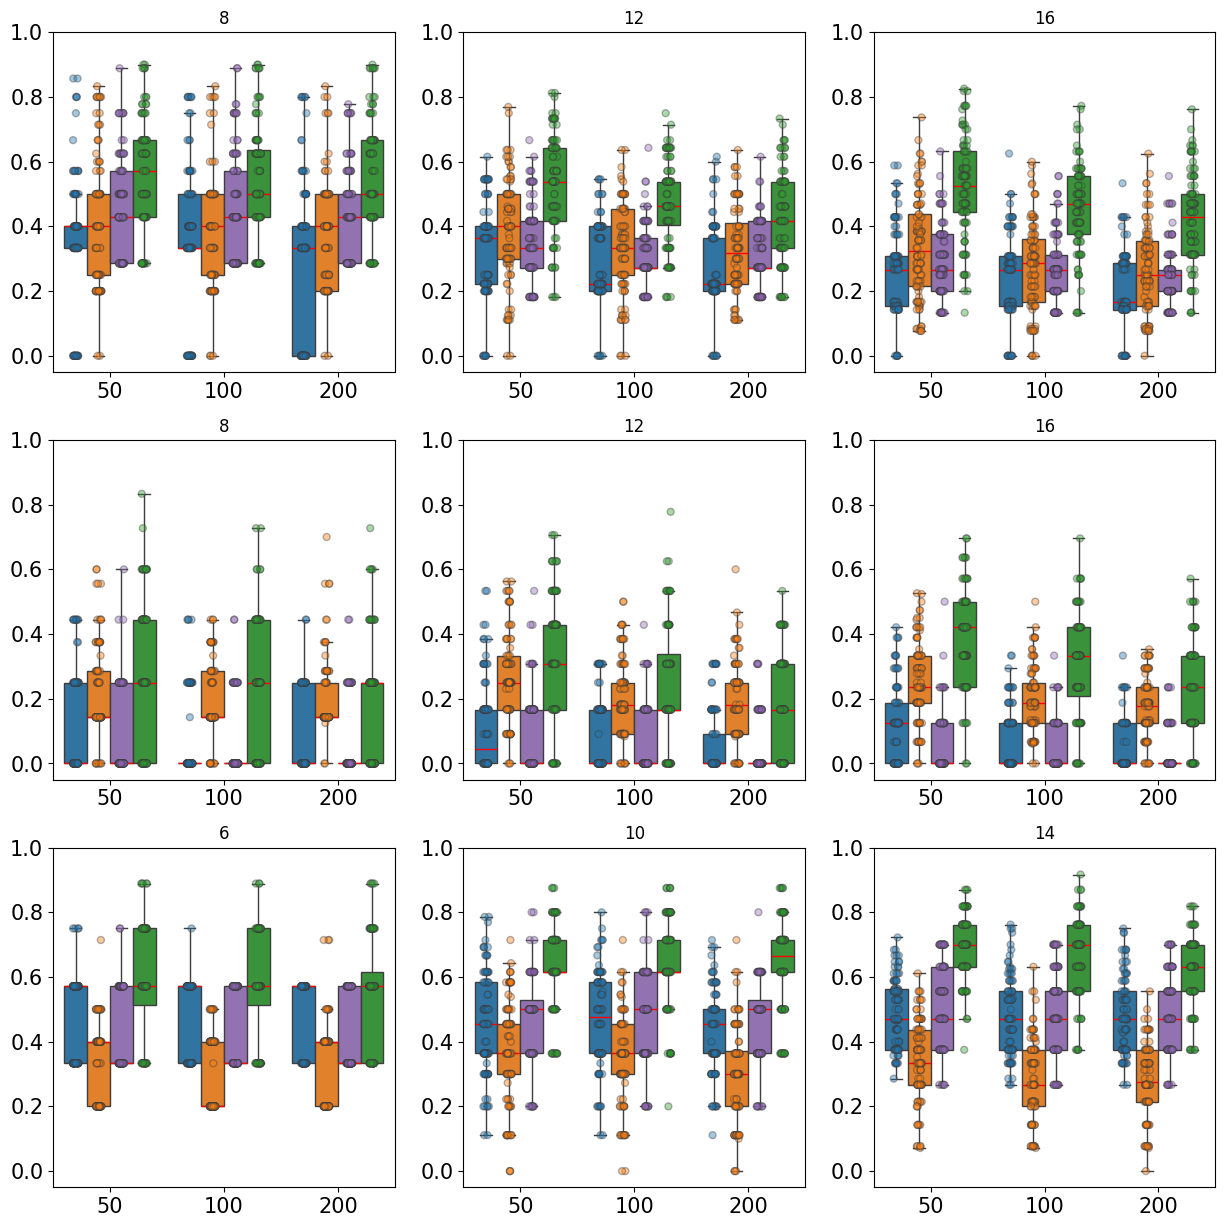

In [45]:
map_types = ["poly_tree", "bin_tree", "graph"]
cell_nums = {"bin_tree": [8, 12, 16], "poly_tree": [8, 12, 16], "graph": [6, 10, 14]}

fig, ax = plt.subplots(3,3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        map_type = map_types[i]
        cell_num = cell_nums[map_type][j]

        df_plot = results[(results["map_type"] == map_type) & (results["cell_types"] == str(cell_num))]
    
        sns.boxplot(x="num_cells", y='jaccard_dist', hue="method", data=df_plot, showfliers = False, ax=ax[i, j], palette= method_color_dictionary, medianprops={'color': 'red'})
        sns.stripplot(data=df_plot, x="num_cells", y="jaccard_dist", hue="method", alpha=.4, dodge=True, linewidth=1, jitter=.1, ax=ax[i, j], palette= method_color_dictionary)
        ax[i,j].set_title(cell_num)
        ax[i,j].get_legend().remove()
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        ax[i,j].set(ylim=(-0.05, 1))

# plt.xticks(rotation=90)
# plt.plot()

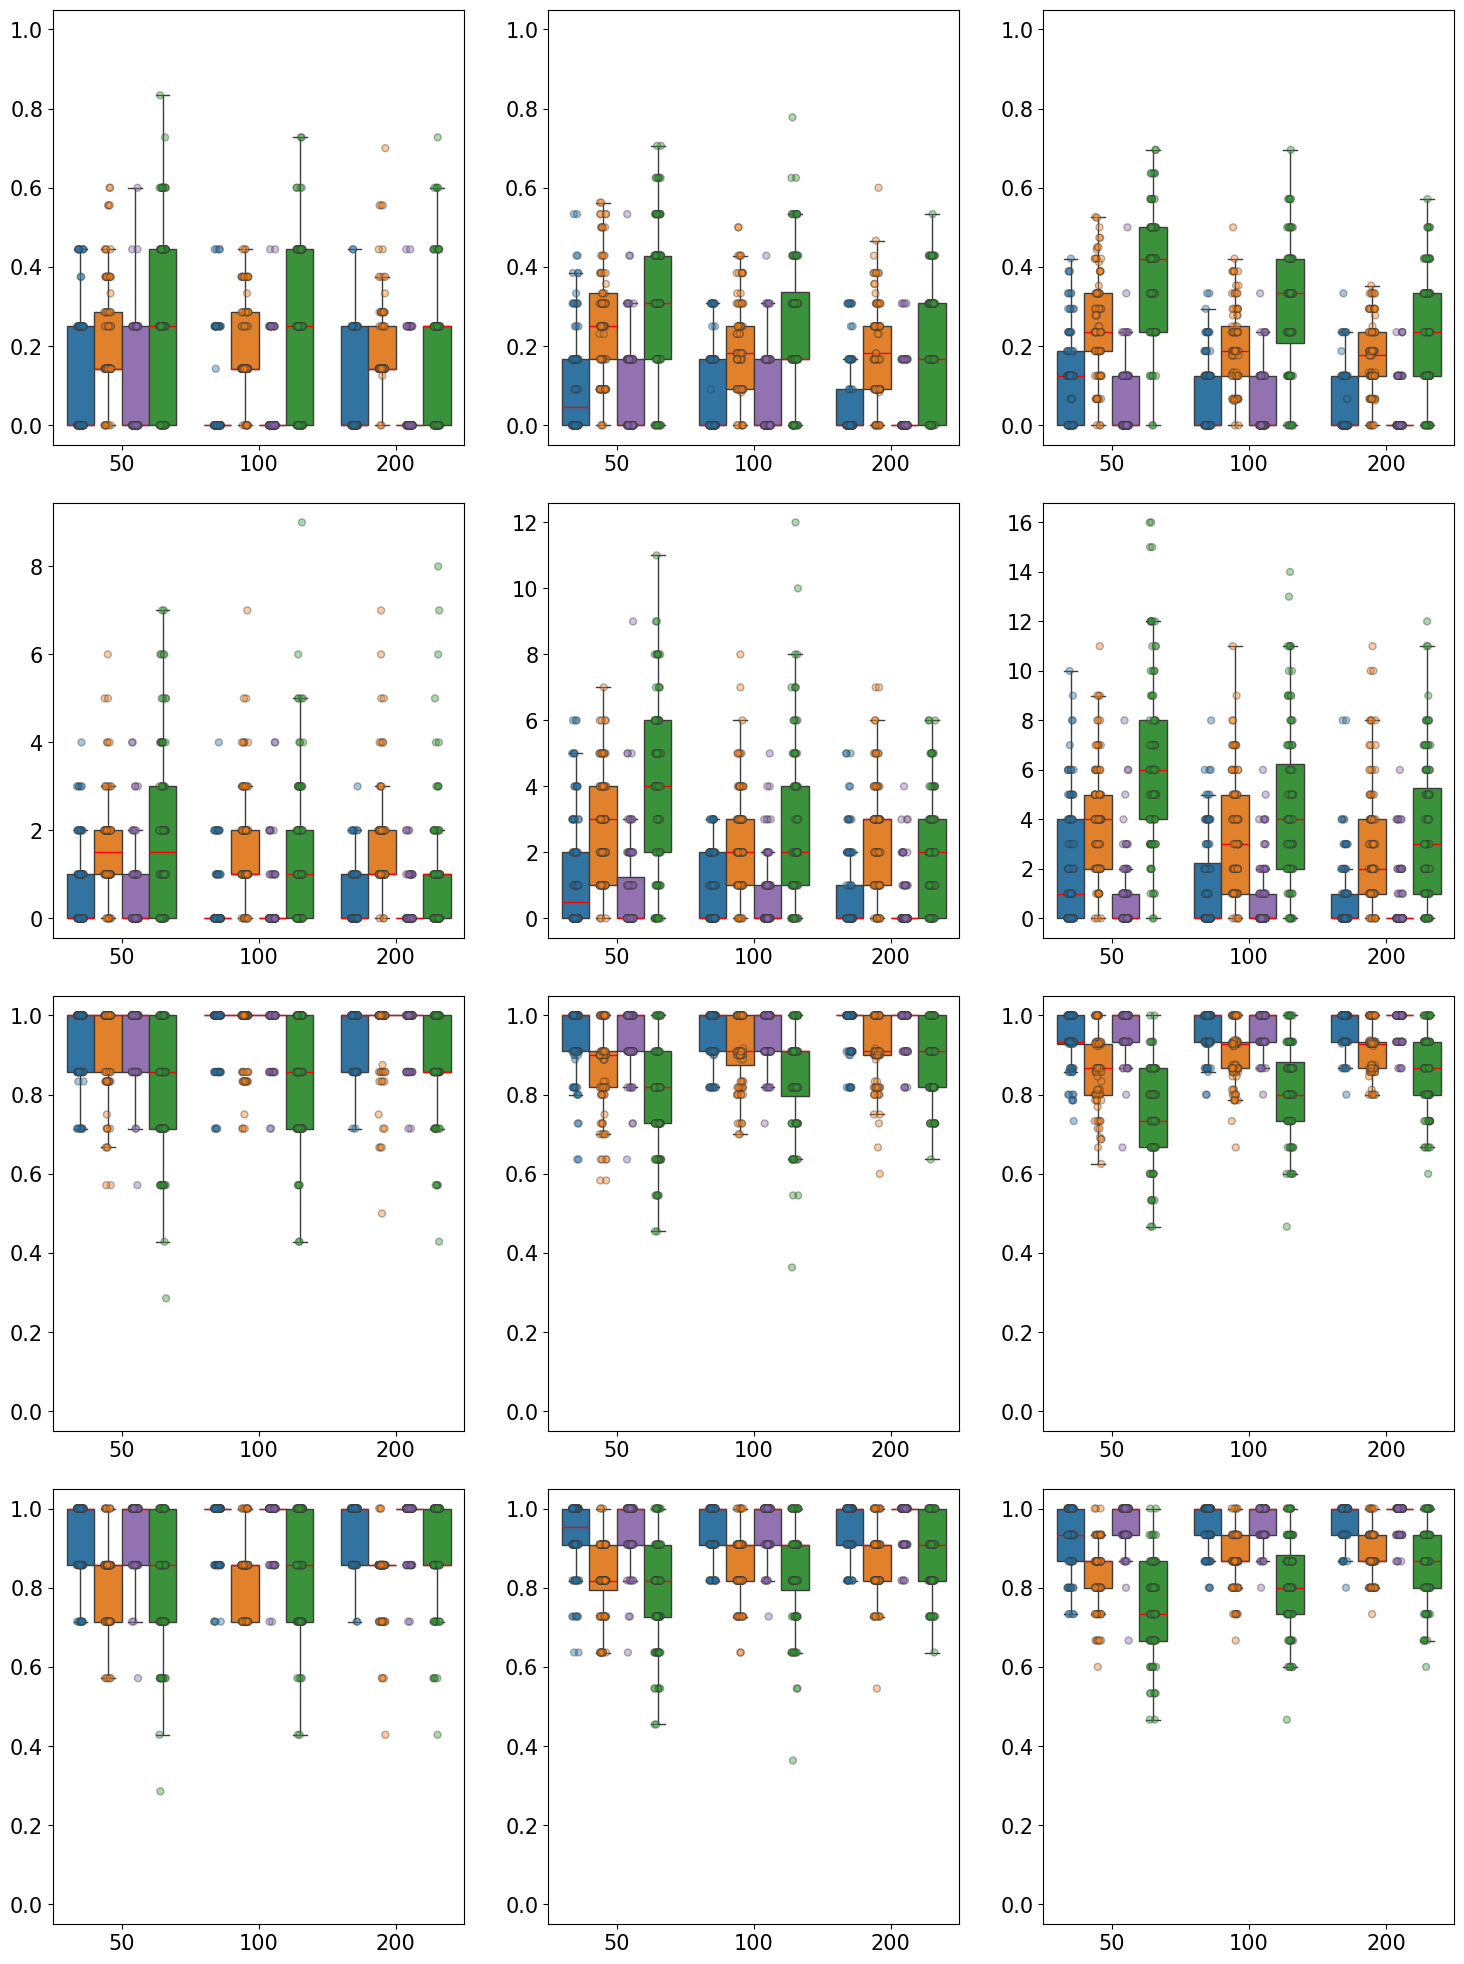

In [46]:
map_type = "bin_tree"
cell_nums = {"bin_tree": [8, 12, 16]}
metrics = ["jaccard_dist", "sum_of_min_symmetric_diff", "precision", "recall"]

fig, ax = plt.subplots(4,3, figsize=(15, 20))

for i in range(4):
    metric = metrics[i]
    for j in range(3):
        cell_num = cell_nums[map_type][j]

        df_plot = results[(results["map_type"] == map_type) & (results["cell_types"] == str(cell_num))]
    
        sns.boxplot(x="num_cells", y=metric, hue="method", data=df_plot, showfliers = False, ax=ax[i, j], palette= method_color_dictionary, medianprops={'color': 'red'})
        sns.stripplot(data=df_plot, x="num_cells", y=metric, hue="method", alpha=.4, dodge=True, linewidth=1, jitter=.1, ax=ax[i, j], palette= method_color_dictionary)
        ax[i,j].set_title("")
        ax[i,j].get_legend().remove()
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        if metric != "sum_of_min_symmetric_diff":
            ax[i,j].set(ylim=(-0.05, 1.05))

fig.tight_layout(pad=2.0)
# plt.xticks(rotation=90)
# plt.plot()

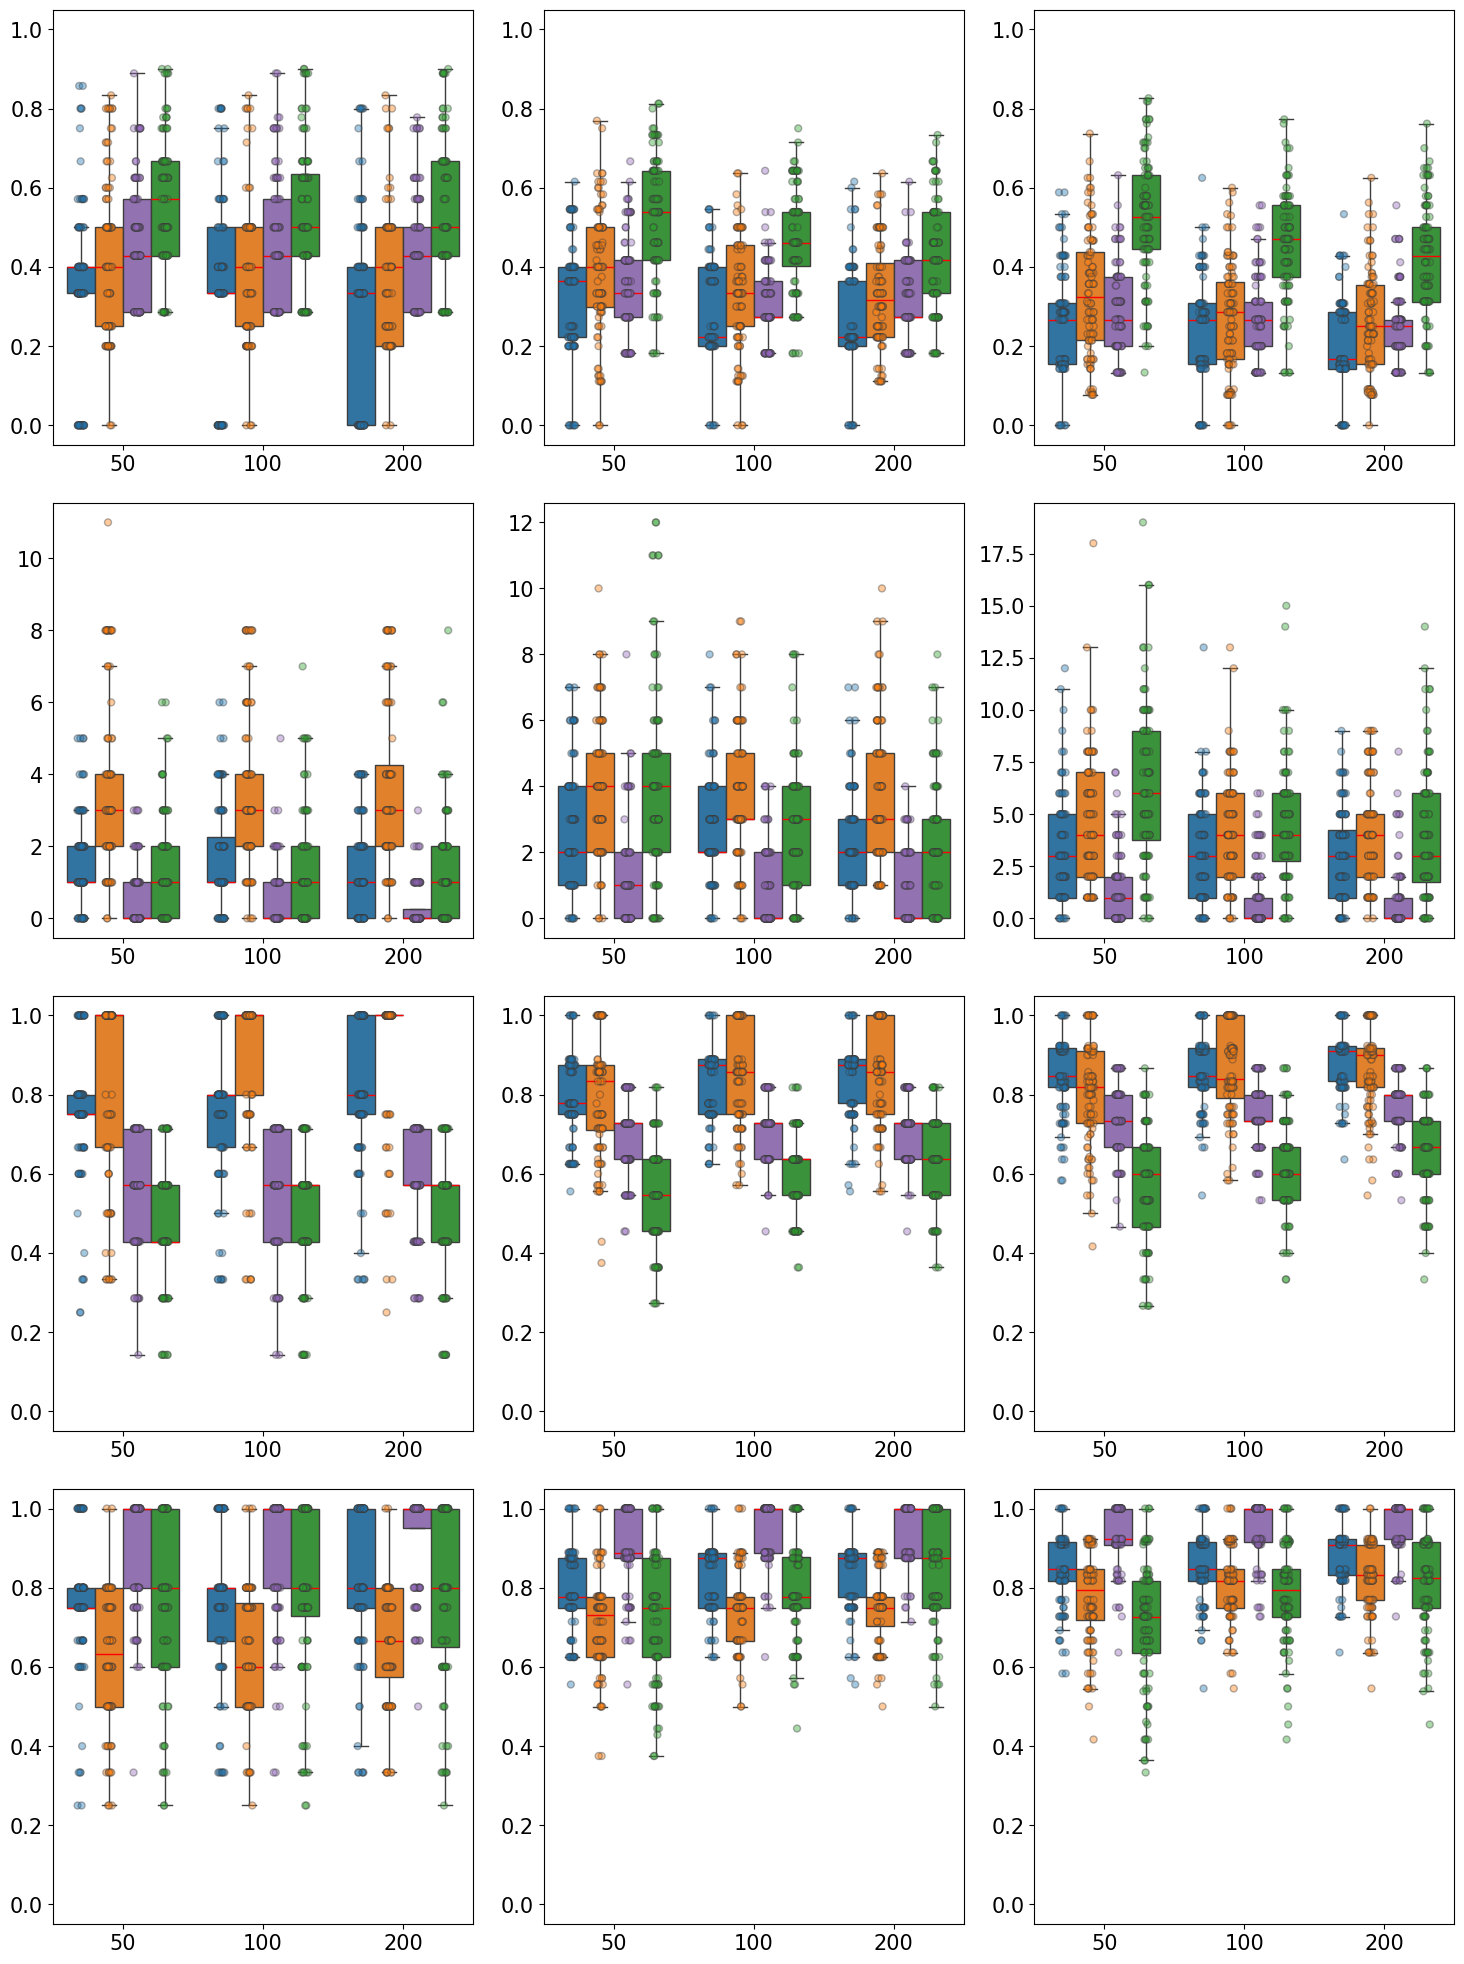

In [47]:
map_type = "poly_tree"
cell_nums = {"poly_tree": [8, 12, 16]}
metrics = ["jaccard_dist", "sum_of_min_symmetric_diff", "precision", "recall"]

fig, ax = plt.subplots(4,3, figsize=(15, 20))

for i in range(4):
    metric = metrics[i]
    for j in range(3):
        cell_num = cell_nums[map_type][j]

        df_plot = results[(results["map_type"] == map_type) & (results["cell_types"] == str(cell_num))]
    
        sns.boxplot(x="num_cells", y=metric, hue="method", data=df_plot, showfliers = False, ax=ax[i, j], palette= method_color_dictionary, medianprops={'color': 'red'})
        sns.stripplot(data=df_plot, x="num_cells", y=metric, hue="method", alpha=.4, dodge=True, linewidth=1, jitter=.1, ax=ax[i, j], palette= method_color_dictionary)
        ax[i,j].set_title("")
        ax[i,j].get_legend().remove()
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        if metric != "sum_of_min_symmetric_diff":
            ax[i,j].set(ylim=(-0.05, 1.05))

fig.tight_layout(pad=2.0)
# plt.xticks(rotation=90)
# plt.plot()

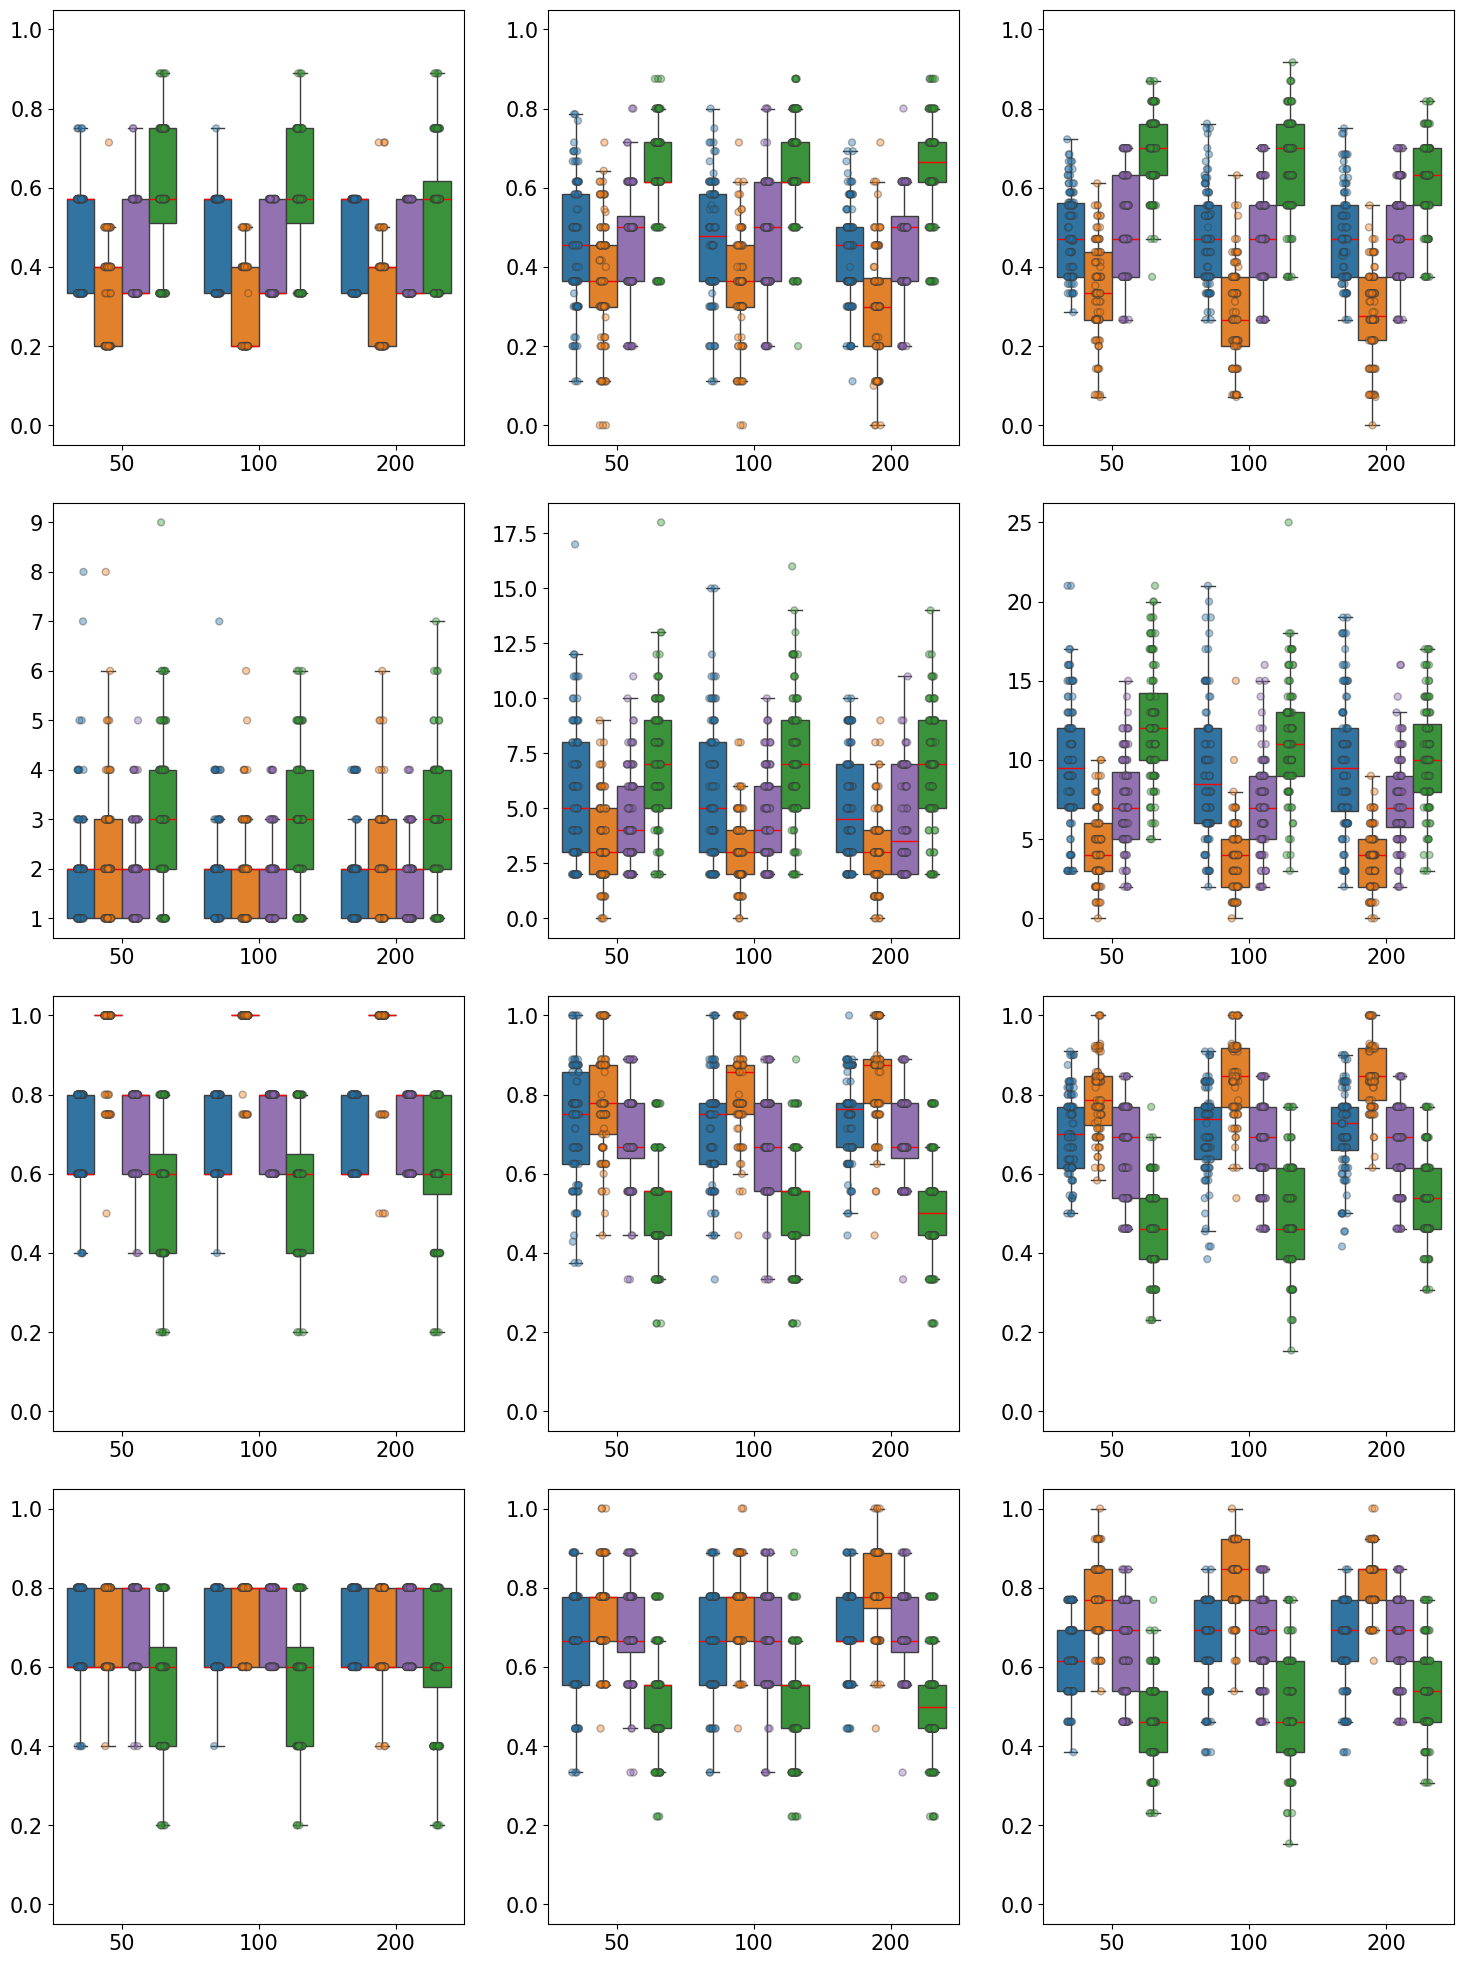

In [48]:
map_type = "graph"
cell_nums = {"graph": [6, 10, 14]}
metrics = ["jaccard_dist", "sum_of_min_symmetric_diff", "precision", "recall"]

fig, ax = plt.subplots(4,3, figsize=(15, 20))

for i in range(4):
    metric = metrics[i]
    for j in range(3):
        cell_num = cell_nums[map_type][j]

        df_plot = results[(results["map_type"] == map_type) & (results["cell_types"] == str(cell_num))]
    
        sns.boxplot(x="num_cells", y=metric, hue="method", data=df_plot, showfliers = False, ax=ax[i, j], palette= method_color_dictionary, medianprops={'color': 'red'})
        sns.stripplot(data=df_plot, x="num_cells", y=metric, hue="method", alpha=.4, dodge=True, linewidth=1, jitter=.1, ax=ax[i, j], palette= method_color_dictionary)
        ax[i,j].set_title("")
        ax[i,j].get_legend().remove()
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")
        if metric != "sum_of_min_symmetric_diff":
            ax[i,j].set(ylim=(-0.05, 1.05))

fig.tight_layout(pad=2.0)
# plt.xticks(rotation=90)
# plt.plot()